In [6]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Add the project root (parent of "nb") to sys.path
project_root = Path("..").resolve()
sys.path.insert(0, str(project_root))

from polypart.arrangements import get_random_arrangement
from polypart.geometry import Hyperplane, Polytope
from polypart.polytopes import sample_poisson_zero_cell_polytope
from polypart.volume import volume_nmz


In [4]:
P = sample_poisson_zero_cell_polytope(3, 1.0, 50)
print(P)
print(f"Volume: {P.volume} = {float(P.volume)} ≈ {4.18879} (4π/3)")

Polytope(dim=3, n_ineq=93, n_vertices=22)


FileNotFoundError: [Errno 2] No such file or directory: 'normaliz'

In [3]:
def estimate_entropy(P: Polytope, cut_hyperplane: Hyperplane):
    """
    Estimate entropy of the split using number of vertices on each side.
    """
    V = P.vertices
    a, b = cut_hyperplane.normal, cut_hyperplane.offset
    num_left = np.sum(np.dot(V, a) < b)
    num_right = np.sum(np.dot(V, a) > b)
    total = num_left + num_right
    p_left = float(num_left / total)
    p_right = float(num_right / total)
    entropy = 0.0
    if p_left > 0:
        entropy -= p_left * np.log2(p_left)
    if p_right > 0:
        entropy -= p_right * np.log2(p_right)
    return entropy


def exact_entropy(P: Polytope, cut_hyperplane: Hyperplane):
    """
    Compute exact entropy of the split using volumes on each side.
    """
    P_left = P.add_halfspace(cut_hyperplane)
    vol_left = P_left.volume
    P_right = P.add_halfspace(-cut_hyperplane)
    vol_right = P_right.volume

    vol_total = vol_left + vol_right
    p_left = float(vol_left / vol_total)
    p_right = float(vol_right / vol_total)

    entropy = 0.0
    if p_left > 0:
        entropy -= p_left * float(np.log2(p_left))
    if p_right > 0:
        entropy -= p_right * float(np.log2(p_right))
    return entropy

In [ ]:
import tqdm

# Check correlation between estimated and exact entropy
dim = 3
num_facets = 10
num_hyperplanes = 500

exact_entropies = []
estimated_entropies = []
for i in tqdm.tqdm(range(num_hyperplanes)):
    P = sample_poisson_zero_cell_polytope(dim, num_facets)
    arrangement = get_random_arrangement(P, num_hyperplanes)
    # print(
    #     f"Polytope with {len(P.vertices)} vertices and {len(arrangement)} hyperplanes."
    # )
    hp = arrangement[i]
    est_entropy = estimate_entropy(P, hp)
    # print(f"Estimated entropy: {est_entropy}")
    ex_entropy = exact_entropy(P, hp)
    # print(f"Exact entropy: {ex_entropy}")
    estimated_entropies.append(est_entropy)
    exact_entropies.append(ex_entropy)


100%|██████████| 500/500 [01:49<00:00,  4.57it/s]


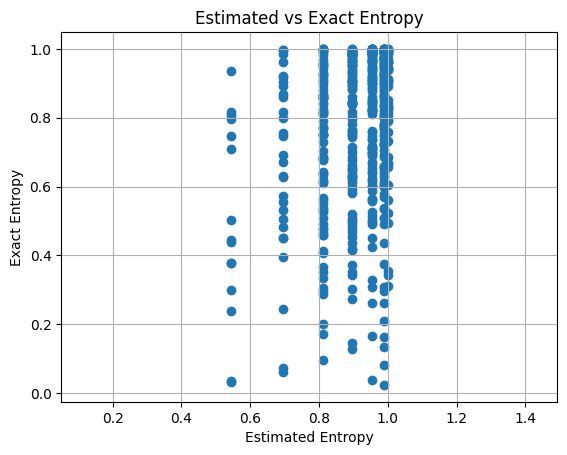

In [5]:
plt.scatter(estimated_entropies, exact_entropies)
plt.xlabel("Estimated Entropy")
plt.ylabel("Exact Entropy")
plt.title("Estimated vs Exact Entropy")
plt.grid(True)
plt.axis("equal")
plt.show()


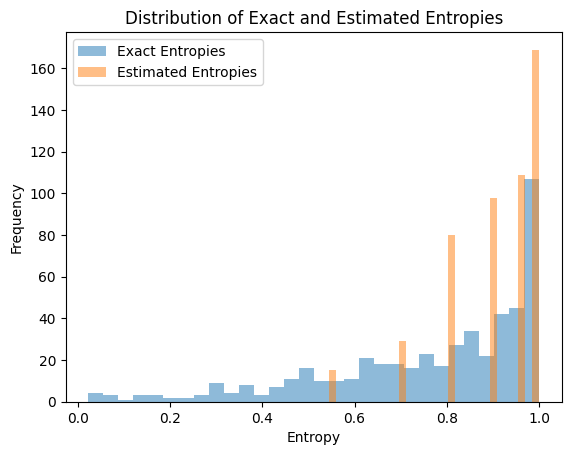

In [6]:
# Plot distribution of real entropies and estimated entropies
plt.hist(exact_entropies, bins=30, alpha=0.5, label="Exact Entropies")
plt.hist(estimated_entropies, bins=30, alpha=0.5, label="Estimated Entropies")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.title("Distribution of Exact and Estimated Entropies")
plt.legend()
plt.show()


In [7]:
# Statistically determine if estimated entropy is a good proxy for exact entropy
from scipy.stats import pearsonr

correlation, p_value = pearsonr(estimated_entropies, exact_entropies)
print(f"Pearson correlation coefficient: {correlation}, p-value: {p_value}")

Pearson correlation coefficient: 0.26669543966680426, p-value: 1.3727682642944524e-09


The pearson test works by measuring the linear correlation between two datasets. In this case, we are comparing the estimated entropies and the exact entropies of the splits. A high positive correlation coefficient (close to 1) indicates that as one variable increases, the other variable tends to also increase, suggesting that the estimated entropy is a good proxy for the exact entropy. The p-value indicates the statistical significance of the correlation; a very low p-value (typically less than 0.05) suggests that the observed correlation is unlikely to have occurred by chance.
